In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
import draw_cnf_mat

import xgboost
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from os.path import exists
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import numpy as np
import time
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
X =np.loadtxt('data/latent_fpkm_gistic_rppa.csv', delimiter=',')


y = np.loadtxt('data/encoded_labels.csv')

input_dim=X.shape[1]

PC= 'Lenovo'
dataset= 'Pan'

num_epochs=200
batch_size=128

num_classes=len(np.unique(y))



target_names=['LumA','LumB', 'Basal', 'Her2',]


In [3]:
#produce results
path = 'data/results_fpkm_gistic_rppa/'
def write_results(results, path):
    
    file_exists = exists(path)
    if not(file_exists):
        with open(path,"a+") as f:
            f.write(results)
            f.write("\n")
    else:
        with open(path,"a+") as f:
            f.write(results)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.20, random_state=42)



def create_model():
    
    #early_stop = EarlyStopping(monitor='loss', patience=2)
    model = Sequential()
        
    model.add(Dense(128, activation='relu', input_shape=(input_dim,),kernel_initializer='random_uniform'))
    model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))

    '''model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
    model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
    model.add(Dense(32, activation='relu',kernel_initializer='random_uniform'))

    model.add(Dense(num_classes, activation='softmax',kernel_initializer='random_uniform'))'''
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    
    return model

2023-03-08 14:23:23.752212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 14:23:23.890333: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-08 14:23:23.890357: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-08 14:23:24.544574: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [5]:
def run_model(i, X,x_train , y_train, x_test , y_test):
    
    t_temp=time.time()
    #individual classifier
    input_dim=x_train.shape[1]

    model1=create_model()
    #hist = model1.fit(x_train , y_train , epochs=20)
    #hist = model1.fit(x_train , y_train , epochs=20, batch_size=5, verbose=0)
    print(x_train.shape)
    hist = model1.fit(x_train , y_train , epochs=num_epochs, batch_size=batch_size, verbose=0)
    y_predict=model1.predict(x_test)
    y_predict=np.argmax(y_predict,axis=1)

    #_, accuracy = model1.evaluate(x_test, y_test)
    #Accuracy
    acc=accuracy_score(y_test, y_predict)
    prc=precision_score(y_test, y_predict, average='weighted')
    rec=recall_score(y_test, y_predict, average='weighted')
    f1=f1_score(y_test, y_predict, average='weighted')
    
 
    results=''
    if (i==0) :
        results='Dataset:' + dataset + '=============================================\n'
        
    results += 'DL:%d' %(i) + ', Acc: %.2f' % (acc*100) + ', Pre: %.2f' % (prc*100)
    results += ', Rec: %.2f' % (rec*100) + ', F1: %.2f' % (f1*100) + ', T:%.2f ' % (time.time()-t_temp) + ', PC:Tan'
    results += ', Eb:%d ' %(num_epochs) + ', Bs:%d ' %(batch_size) + '\n'
    
    path2= path + "Res_Singl_DL_Original.txt" # the name of the file
    write_results(results, path2)
    predictions=model1.predict(X)
    max_indices = np.argmax(predictions,axis=1)


    return np.array(max_indices)

In [6]:

t=time.time()
predictions=run_model(0, X,x_train , y_train, x_test , y_test)
for i in range(1,5):
    predictions=np.vstack((predictions,run_model(i, X,x_train , y_train, x_test , y_test)))

predictions= np.transpose(predictions)

# concat predictions with olriginal features
new_X=np.concatenate((X, predictions), axis=1)
#new_X=predictions #np.concatenate((X, predictions), axis=1)
#====z_score normalization
scaler = StandardScaler()
scaler.fit(new_X)
new_X = scaler.fit_transform(new_X)
print(new_X.shape, predictions.shape)

new_x_train,new_x_test,y_train,y_test = train_test_split(new_X,y,test_size = 0.20, random_state=42)

input_dim=new_X.shape[1]


2023-03-08 14:23:25.220904: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-08 14:23:25.220943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alandoli-Lenovo-Z50-70): /proc/driver/nvidia/version does not exist
2023-03-08 14:23:25.221407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(408, 100)
16/16 [==============================] - 0s 2ms/step
(408, 100)
16/16 [==============================] - 0s 1ms/step
(408, 100)
16/16 [==============================] - 0s 1ms/step
(408, 100)
16/16 [==============================] - 0s 1ms/step
(408, 100)
16/16 [==============================] - 0s 1ms/step
(511, 105) (511, 5)


In [7]:
input_dim=new_x_train.shape[1]

NN_clf1=KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=batch_size, verbose=0)
NN_clf1._estimator_type = "classifier"
NN_clf2=KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=batch_size, verbose=0)
NN_clf2._estimator_type = "classifier"
NN_clf3=KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=batch_size, verbose=0)
NN_clf3._estimator_type = "classifier"
NN_clf4=KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=batch_size, verbose=0)
NN_clf4._estimator_type = "classifier"
NN_clf5=KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=batch_size, verbose=0)
NN_clf5._estimator_type = "classifier"
input_dim


/tmp/ipykernel_24229/703522063.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  NN_clf1=KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=batch_size, verbose=0)
/tmp/ipykernel_24229/703522063.py:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  NN_clf2=KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=batch_size, verbose=0)
/tmp/ipykernel_24229/703522063.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  NN_clf3=KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=batch_size, verbose=0)
/tmp

105

In [8]:
rfc = RandomForestClassifier()
knn =  KNeighborsClassifier()
xgb = xgboost.XGBClassifier()
LR=LogisticRegression(solver='liblinear')
intermediate = [('NN1', NN_clf1), ('NN2', NN_clf2), ('NN3', NN_clf3), ('NN4', NN_clf4),
             ('NN5', NN_clf5),('rfc', rfc),('LR', LR),('xgb', xgb), ]
intermediate


[('NN1', <keras.wrappers.scikit_learn.KerasClassifier at 0x7fc09b70abf0>),
 ('NN2', <keras.wrappers.scikit_learn.KerasClassifier at 0x7fc0904040d0>),
 ('NN3', <keras.wrappers.scikit_learn.KerasClassifier at 0x7fc090406830>),
 ('NN4', <keras.wrappers.scikit_learn.KerasClassifier at 0x7fc090383370>),
 ('NN5', <keras.wrappers.scikit_learn.KerasClassifier at 0x7fc0903833a0>),
 ('rfc', RandomForestClassifier()),
 ('LR', LogisticRegression(solver='liblinear')),
 ('xgb',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=No

In [9]:
# run after ad preictions of first level
t1=time.time()
i=0
results="Dataset: " + dataset + "================================\n"
clf = [NN_clf1,NN_clf2,NN_clf3,NN_clf4, NN_clf5, rfc, LR, xgb]
for algo in clf:
    t_temp=time.time()
    y_predict = cross_val_predict(algo,new_X,y, cv=3) 
    #score = cross_val_score( algo,new_X,y,cv = 10,scoring = 'accuracy')
    #print("The accuracy score of {} is:".format(algo),score.mean(), "time: ", time.time()-t_temp)
    acc=accuracy_score(y_predict,y)
    prc=precision_score(y_predict,y, average='weighted')
    rec=recall_score(y_predict,y, average='weighted')
    f1=f1_score(y_predict,y, average='weighted')


    results = 'DL:%d' %(i) + ', Acc: %.2f' % (acc*100) + ', Pre: %.2f' % (prc*100)
    results += ', Rec: %.2f' % (rec*100) + ', F1: %.2f' % (f1*100) + ', T:%.2f ' % (time.time()-t_temp) + ', PC:Tan'
    results += ', Eb:%d ' %(num_epochs) + ', Bs:%d ' %(batch_size) + '\n'
    
    path2= path + "Res_Singl_DL_after.txt" # the name of the file
    write_results(results, path2)

    i=i+1
    #print(results)

    '''path="results/Res_Singl_DL_Original.txt" # the name of the file
    write_results(results, path)'''

print("Done...in time: ", time.time()-t1)

6/6 [==============================] - 0s 2ms/step
Done...in time:  34.62389373779297


4/4 [==============================] - 0s 2ms/step


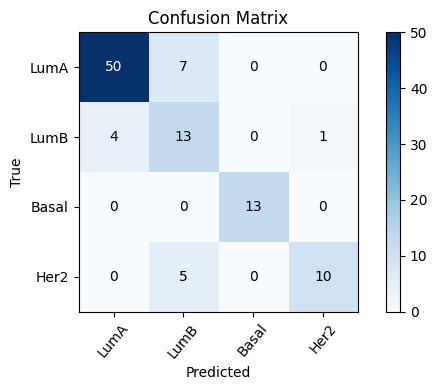

Done...in time:  68.09044003486633


In [10]:
t2=time.time()
#kfold = KFold(n_splits=10, shuffle=True)
clf = StackingClassifier(estimators=intermediate, final_estimator=LogisticRegression()) #MLPClassifier()

clf.fit(new_x_train , y_train)
#score = cross_val_score(stack_model,new_X,y,cv = 10,scoring = 'accuracy')
#score
y_predict=clf.predict(new_x_test)
acc=accuracy_score(y_predict,y_test)
prc=precision_score(y_predict,y_test, average='weighted')
rec=recall_score(y_predict,y_test, average='weighted')
f1=f1_score(y_predict,y_test, average='weighted')
confus_matrix= classification_report(y_test, y_predict)

results ='Acc: %.2f' % (acc*100) + ', Pre: %.2f' % (prc*100)
results += ', Rec: %.2f' % (rec*100) + ', F1: %.2f' % (f1*100) + ', T:%.2f ' % (time.time()-t_temp) + ', PC:Tan'
results += ', Eb:%d ' %(num_epochs) + ', Bs:%d ' %(batch_size) + 'Dataset: ' + dataset + '\n'
results += 'Confusion matrix :\n' + confus_matrix + '=======================\n'


path2= path + "Res_Ensemble_DL.txt" # the name of the file
write_results(results, path2)

draw_cnf_mat.draw(y_test, y_predict, 'Res_Ensemble_DL', target_names)

print("Done...in time: ", time.time()-t2)

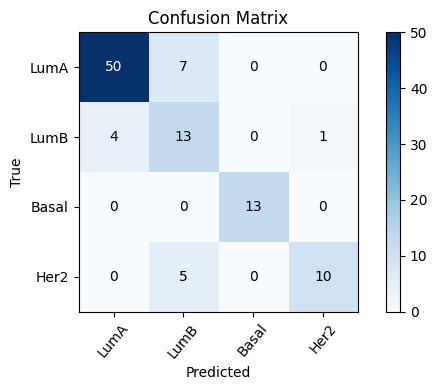

Done...in time:  68.68629622459412


In [11]:
draw_cnf_mat.draw(y_test, y_predict, 'Res_Ensemble_DL', target_names)

print("Done...in time: ", time.time()-t2)

In [12]:
print("Stacking model score: %.3f" % clf.score(new_x_test , y_test))

4/4 [==============================] - 0s 2ms/step
Stacking model score: 0.835


In [13]:
print(classification_report(y_predict,y_test), '\n')

              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90        54
         1.0       0.72      0.52      0.60        25
         2.0       1.00      1.00      1.00        13
         3.0       0.67      0.91      0.77        11

    accuracy                           0.83       103
   macro avg       0.82      0.84      0.82       103
weighted avg       0.83      0.83      0.83       103
 

